#Bibliotecas

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns



from sklearn.tree import DecisionTreeClassifier
from xgboost import XGBClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
from sklearn.metrics import (roc_auc_score, roc_curve, classification_report,
    confusion_matrix,
    accuracy_score,
    precision_score,
    recall_score,
    f1_score, log_loss
)



#Carregando os dados

In [ ]:
!pip install --upgrade google-cloud-bigquery pandas-gbq

from google.colab import auth
auth.authenticate_user()

import pandas_gbq


In [ ]:
# Configurar seu projeto
project_id = 'proj-03-458217'
dataset = 'proj03lab'
tabela = 'analise'

# Consulta SQL para carregar tudo
query = f"""
SELECT *
FROM `{project_id}.{dataset}.{tabela}`
"""

# Lendo para um DataFrame
import pandas as pd
data = pandas_gbq.read_gbq(query, project_id=project_id)

# Visualizar os dados como antes
print("Total de linhas:", len(data))
data.head()


Downloading: 100%|██████████|
Total de linhas: 35575


,user_id,last_month_salary,age,faixa_idade,number_dependents,faixa_dependentes,more_90_days_overdue,using_lines_not_secured_personal_assets,debt_ratio,default_flag,...,risco_relativo_debt_ratio,risco_relativo_more_90_days_overdue,risco_relativo_using_lines_not_secured_personal_assets,dummy_idade_risco,dummy_salario_risco,dummy_emprestimos_risco,dummy_debt_ratio_risco,dummy_90dias_risco,dummy_linhas_credito_risco,score_risco_total
0,13372,2000.0,21,até 29,0,0,0,0.000000,0.000000,0,...,0.797405,3.743081,0.051445,1,1,1,0,1,0,3
1,4732,550.0,21,até 29,0,0,0,1.000000,0.176044,0,...,0.797405,0.070738,3.755944,1,1,1,0,0,1,3
2,18682,5366.0,21,até 29,0,0,0,1.000000,34.000000,0,...,1.029026,0.070738,3.755944,1,0,1,0,0,1,2
3,2932,5366.0,21,até 29,0,0,0,0.445078,9.000000,0,...,1.029026,3.743081,0.186490,1,0,1,0,1,0,2
4,8870,5366.0,21,até 29,<NA>,ausente,0,1.000000,0.000000,0,...,0.797405,0.064307,3.755944,1,0,1,0,0,1,2


#Matriz de confusão

Uma matriz de confusão é uma tabela que confronta as categorias reais com as categorias previstas por um modelo de classificação, mostrando onde ele acerta e onde erra. Ela indica, de um lado, quantos casos positivos foram corretamente identificados como positivos e quantos casos negativos foram corretamente identificados como negativos; e, do outro, quantas vezes o modelo classificou como positivo algo que era negativo (falsos positivos) e quantas vezes classificou como negativo algo que era positivo (falsos negativos). Com esses quatro valores em mãos, podemos avaliar de forma detalhada o desempenho do classificador: a proporção de predições corretas em relação ao total de casos, a confiabilidade das previsões positivas, a capacidade de capturar todos os casos positivos e um indicador que equilibra esses dois aspectos. Em problemas com desequilíbrio entre as classes (quando há muito mais exemplos de um tipo do que de outro), a matriz de confusão é especialmente útil para revelar se o modelo está simplesmente ignorando a classe menos frequente ou gerando muitos alarmes falsos. Além disso, a leitura dessa matriz ajuda a ajustar o ponto de corte do classificador, de modo a encontrar o melhor equilíbrio entre identificar corretamente os casos de interesse e evitar classificações equivocadas.

##Regressão Logística

A regressão logística é um algoritmo de aprendizado supervisionado usado para tarefas de classificação binária; ele estima a probabilidade de um evento ocorrer a partir de uma combinação linear das variáveis independentes, aplicando a função logística para mapear essa combinação em um valor entre 0 e 1. A Regressão foi realizada com as variáveis de risco relativo de idade, salário, atraso >90 dias e uso de linhas não garantidas. Ajustou-se o modelo para limiar de decisão 0.5.

###Com Risco Relativo

In [ ]:
print("Distribuição dos valores em default_flag:")
print(data['default_flag'].value_counts())


Distribuição dos valores em default_flag:
default_flag
0    34953
1      622
Name: count, dtype: Int64


#### Teste


 MODELO COM SCORE DE RISCO TOTAL:
Acurácia: 0.9049002154970486
AUC-ROC: 0.954479881010359
Classification Report:
               precision    recall  f1-score   support

         0.0       1.00      0.90      0.95     10455
         1.0       0.17      0.91      0.28       218

    accuracy                           0.90     10673
   macro avg       0.58      0.91      0.62     10673
weighted avg       0.98      0.90      0.94     10673



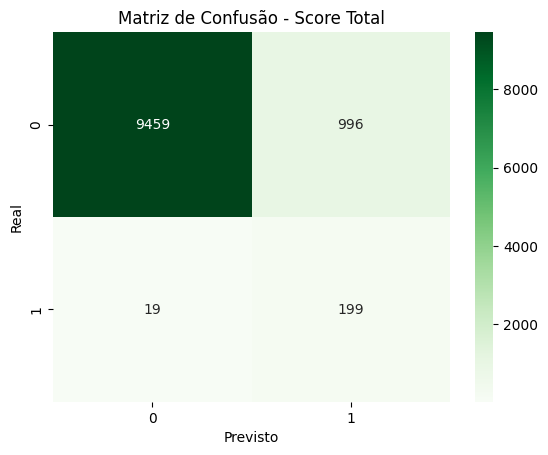

In [ ]:
# Criando a variavél de score
data['score_risco_relativo_total'] = (
    data['risco_relativo_idade'] +
    data['risco_relativo_salario'] +
    data['risco_relativo_more_90_days_overdue'] +
    data['risco_relativo_using_lines_not_secured_personal_assets']
)


X = data[['score_risco_relativo_total']]
y = data['default_flag']

X_score = data[['score_risco_relativo_total']]

X_train_s, X_test_s, y_train_s, y_test_s = train_test_split(X_score, y, test_size=0.3, random_state=42)

modelo_score = LogisticRegression(class_weight='balanced', max_iter=1000)
modelo_score.fit(X_train_s, y_train_s)

y_pred_s = modelo_score.predict(X_test_s)
y_prob_s = modelo_score.predict_proba(X_test_s)[:, 1]

print("\n MODELO COM SCORE DE RISCO TOTAL:")
print("Acurácia:", accuracy_score(y_test_s, y_pred_s))
print("AUC-ROC:", roc_auc_score(y_test_s, y_prob_s))
print("Classification Report:\n", classification_report(y_test_s, y_pred_s, zero_division=0))

# Matriz de confusão
cm_s = confusion_matrix(y_test_s, y_pred_s)
sns.heatmap(cm_s, annot=True, fmt='d', cmap='Greens')
plt.title("Matriz de Confusão - Score Total")
plt.xlabel("Previsto")
plt.ylabel("Real")
plt.show()

Avaliação do Modelo (com todos os dados):

Acurácia: 0.932789880534083
AUC-ROC: 0.9515058945025212
Classification Report:
               precision    recall  f1-score   support

         0.0       1.00      0.93      0.96     34953
         1.0       0.19      0.87      0.31       622

    accuracy                           0.93     35575
   macro avg       0.59      0.90      0.64     35575
weighted avg       0.98      0.93      0.95     35575



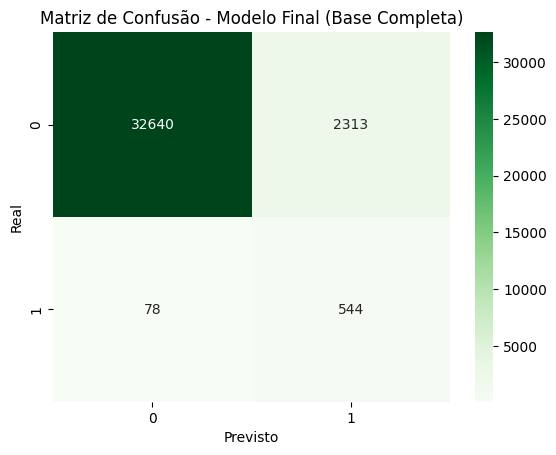

In [ ]:
# Variaveis utilizadas
colunas_usadas = [
    'risco_relativo_idade',
    'risco_relativo_salario',
    'risco_relativo_more_90_days_overdue',
    'risco_relativo_using_lines_not_secured_personal_assets'
]

# Separando X e y
X = data[colunas_usadas]
y = data['default_flag']

# Criando e treinando o modelo com todos os dados
modelo = LogisticRegression(max_iter=1000, class_weight='balanced')
modelo.fit(X, y)

# Fazendo as previsões
data['previsao_inadimplente'] = modelo.predict(X)
data['probabilidade_inadimplencia'] = modelo.predict_proba(X)[:, 1]

# Avaliando o modelo
print("Avaliação do Modelo (com todos os dados):\n")
print("Acurácia:", accuracy_score(y, data['previsao_inadimplente']))
print("AUC-ROC:", roc_auc_score(y, data['probabilidade_inadimplencia']))
print("Classification Report:\n", classification_report(y, data['previsao_inadimplente'], zero_division=0))

# Matriz de confusão
cm = confusion_matrix(y, data['previsao_inadimplente'])
sns.heatmap(cm, annot=True, fmt='d', cmap='Greens')
plt.title("Matriz de Confusão - Modelo Final (Base Completa)")
plt.xlabel("Previsto")
plt.ylabel("Real")
plt.show()


A matriz de confusão mostrou 32.640 verdadeiros negativos, 2.313 falsos positivos, 78 falsos negativos e 544 verdadeiros positivos. Com isso, a acurácia geral foi de 0,93, indicando que 93% das classificações estão corretas — valor elevado, mas influenciado pela forte predominância de clientes adimplentes na base. Para a classe 0 (adimplentes), o modelo apresentou precisão de 1,00, recall de 0,93 e F1-score de 0,96, evidenciando excelente capacidade de identificar corretamente quem paga em dia, sem quase nenhum erro de classificação. Já para a classe 1 (inadimplentes), a precisão foi de apenas 0,19, enquanto o recall atingiu 0,87, resultando em um F1-score de 0,31. Isso indica que, embora o modelo consiga identificar a maioria dos inadimplentes (alta sensibilidade), ele também comete muitos falsos alarmes — classificando muitos adimplentes como devedores.

In [ ]:
print(data.columns)
print(data[['previsao_inadimplente', 'probabilidade_inadimplencia']].head())


Index(['user_id', 'last_month_salary', 'age', 'faixa_idade',
       'number_dependents', 'faixa_dependentes', 'more_90_days_overdue',
       'using_lines_not_secured_personal_assets', 'debt_ratio', 'default_flag',
       'total_emprestimos', 'qtde_real_estate', 'qtde_other',
       'quartil_salario', 'quartil_age', 'quartil_debt_ratio',
       'quartil_using_lines_not_secured_personal_assets',
       'quartil_total_emprestimos', 'quartil_more_90_days_overdue',
       'risco_relativo_idade', 'risco_relativo_salario',
       'risco_relativo_total_emprestimos', 'risco_relativo_debt_ratio',
       'risco_relativo_more_90_days_overdue',
       'risco_relativo_using_lines_not_secured_personal_assets',
       'dummy_idade_risco', 'dummy_salario_risco', 'dummy_emprestimos_risco',
       'dummy_debt_ratio_risco', 'dummy_90dias_risco',
       'dummy_linhas_credito_risco', 'score_risco_total',
       'score_risco_relativo_total', 'previsao_inadimplente',
       'probabilidade_inadimplencia'],
   

In [ ]:
tabela_destino = 'analise_risco'
data.to_gbq(
    destination_table=f"{dataset}.{tabela_destino}",
    project_id=project_id,
    if_exists='replace'
)


<ipython-input-12-bf4f469202bc>:2: FutureWarning: to_gbq is deprecated and will be removed in a future version. Please use pandas_gbq.to_gbq instead: https://pandas-gbq.readthedocs.io/en/latest/api.html#pandas_gbq.to_gbq
  data.to_gbq(
100%|██████████| 1/1 [00:00<00:00, 2098.20it/s]


### Com Dummy

#### Teste


 MODELO COM DUMMIES:
Acurácia: 0.9347887191979762
AUC-ROC: 0.9503757913995761
Classification Report:
               precision    recall  f1-score   support

         0.0       1.00      0.94      0.97     10455
         1.0       0.22      0.89      0.36       218

    accuracy                           0.93     10673
   macro avg       0.61      0.92      0.66     10673
weighted avg       0.98      0.93      0.95     10673



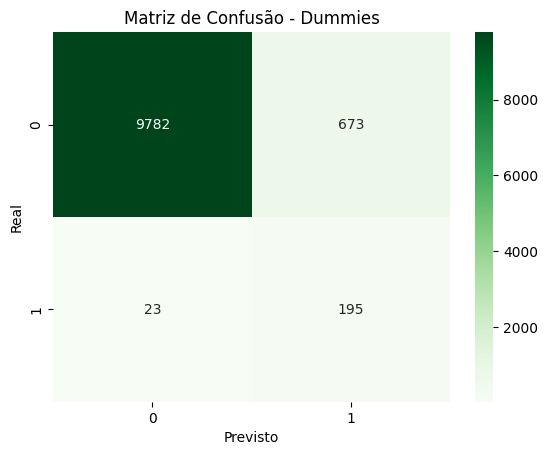

In [ ]:
colunas_dummies = [
    'dummy_idade_risco',
    'dummy_salario_risco',
    'dummy_90dias_risco',
    'dummy_linhas_credito_risco'
]

# Variável alvo
y = data['default_flag']

X_dummies = data[colunas_dummies]

# Separar treino e teste
X_train_d, X_test_d, y_train_d, y_test_d = train_test_split(X_dummies, y, test_size=0.3, random_state=42)

# Criar modelo com balanceamento
modelo_dummies = LogisticRegression(class_weight='balanced', max_iter=1000)
modelo_dummies.fit(X_train_d, y_train_d)

# Previsões
y_pred_d = modelo_dummies.predict(X_test_d)
y_prob_d = modelo_dummies.predict_proba(X_test_d)[:, 1]

# Avaliação
print("\n MODELO COM DUMMIES:")
print("Acurácia:", accuracy_score(y_test_d, y_pred_d))
print("AUC-ROC:", roc_auc_score(y_test_d, y_prob_d))
print("Classification Report:\n", classification_report(y_test_d, y_pred_d, zero_division=0))

# Matriz de confusão
cm_d = confusion_matrix(y_test_d, y_pred_d)
sns.heatmap(cm_d, annot=True, fmt='d', cmap='Greens')
plt.title("Matriz de Confusão - Dummies")
plt.xlabel("Previsto")
plt.ylabel("Real")
plt.show()

####Modelo final

AVALIAÇÃO FINAL (base completa):
Acurácia: 0.932789880534083
AUC-ROC: 0.9465708567950182
Relatório de Classificação:
               precision    recall  f1-score   support

         0.0       1.00      0.93      0.96     34953
         1.0       0.19      0.87      0.31       622

    accuracy                           0.93     35575
   macro avg       0.59      0.90      0.64     35575
weighted avg       0.98      0.93      0.95     35575



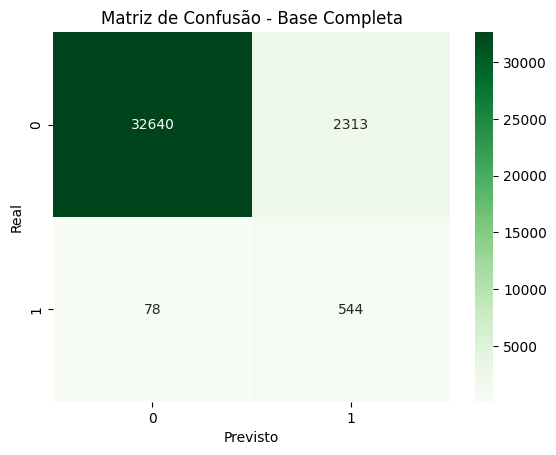

In [ ]:
# Variáveis explicativas
colunas_dummies = [
    'dummy_idade_risco',
    'dummy_salario_risco',
     'dummy_90dias_risco',
    'dummy_linhas_credito_risco'
]

# Variável alvo
X = data[colunas_dummies]
y = data['default_flag']

# Criar e treinar o modelo com todos os dados
modelo_final = LogisticRegression(class_weight='balanced', max_iter=1000)
modelo_final.fit(X, y)

# Fazer previsões com base na base inteira
data['probabilidade_inadimplencia'] = modelo_final.predict_proba(X)[:, 1]
data['previsao_inadimplente'] = modelo_final.predict(X)

# Avaliação do modelo nos dados completos (para entendimento, não validação)
print("AVALIAÇÃO FINAL (base completa):")
print("Acurácia:", accuracy_score(y, data['previsao_inadimplente']))
print("AUC-ROC:", roc_auc_score(y, data['probabilidade_inadimplencia']))
print("Relatório de Classificação:\n", classification_report(y, data['previsao_inadimplente'], zero_division=0))

# Matriz de confusão
cm = confusion_matrix(y, data['previsao_inadimplente'])
sns.heatmap(cm, annot=True, fmt='d', cmap='Greens')
plt.title("Matriz de Confusão - Base Completa")
plt.xlabel("Previsto")
plt.ylabel("Real")
plt.show()


### AUC ROC

A avaliação por meio da curva ROC (Receiver Operating Characteristic) e da métrica AUC (Area Under the Curve) quantifica a habilidade do modelo em distinguir exemplos positivos de negativos em todos os possíveis limiares de decisão. A AUC corresponde à probabilidade de que, ao comparar uma instância positiva e uma negativa aleatórias, o modelo atribua uma pontuação maior à positiva; valores próximos a 1 indicam forte capacidade discriminativa, enquanto 0,5 aponta desempenho equivalente a um palpite aleatório.

AUC-ROC Score (Regressão Logística): 0.9519


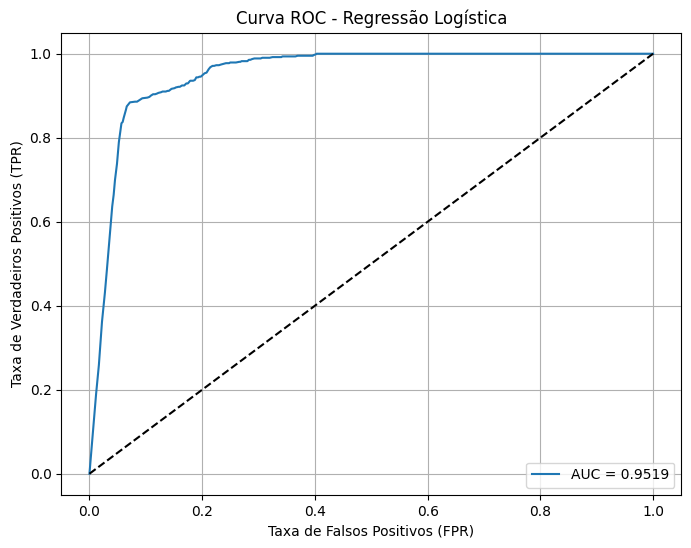

In [ ]:

# 2. Selecionar as variáveis explicativas e a target (default_flag)
features = [
    'risco_relativo_idade',
    'risco_relativo_salario',
    'risco_relativo_more_90_days_overdue',
    'risco_relativo_using_lines_not_secured_personal_assets'
]
X = data[features]
y = data['default_flag']

# 3. Criar e treinar o modelo com toda a base
modelo = LogisticRegression(max_iter=1000)
modelo.fit(X, y)

# 4. Obter as probabilidades preditas
y_probs = modelo.predict_proba(X)[:, 1]  # probabilidade da classe 1

# 5. Calcular o AUC-ROC
auc = roc_auc_score(y, y_probs)
print(f"AUC-ROC Score (Regressão Logística): {auc:.4f}")

# 6. Plotar a curva ROC
fpr, tpr, _ = roc_curve(y, y_probs)

plt.figure(figsize=(8,6))
plt.plot(fpr, tpr, label=f'AUC = {auc:.4f}')
plt.plot([0, 1], [0, 1], 'k--')  # linha de referência
plt.title('Curva ROC - Regressão Logística')
plt.xlabel('Taxa de Falsos Positivos (FPR)')
plt.ylabel('Taxa de Verdadeiros Positivos (TPR)')
plt.legend(loc='lower right')
plt.grid(True)
plt.show()


##XGBoost

O XGBoost (eXtreme Gradient Boosting) é uma biblioteca voltada a implementar de forma escalável e eficiente o framework de Gradient Boosted Decision Trees (GBDT). Por meio de iterações sucessivas, o algoritmo ajusta novos modelos de árvore para corrigir os erros residuais dos anteriores, utilizando derivadas segunda ordem e regularização para melhorar a generalização.


/usr/local/lib/python3.11/dist-packages/xgboost/core.py:158: UserWarning: [13:11:55] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


XGBoost (com balanceamento):
[[31202  3751]
 [   40   582]]
              precision    recall  f1-score   support

         0.0       1.00      0.89      0.94     34953
         1.0       0.13      0.94      0.23       622

    accuracy                           0.89     35575
   macro avg       0.57      0.91      0.59     35575
weighted avg       0.98      0.89      0.93     35575



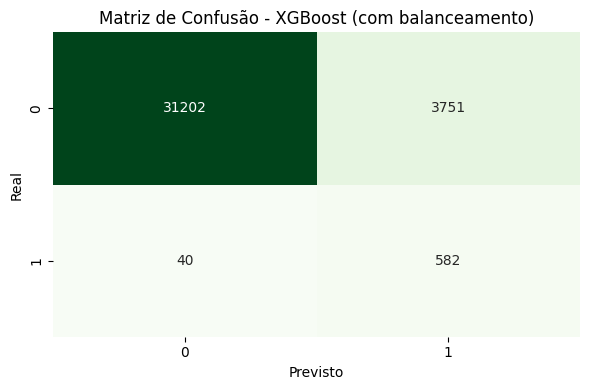

In [ ]:


# Calcular proporção inversa
neg, pos = (y == 0).sum(), (y == 1).sum()
peso = neg / pos  # Ex: ~56

# Recriar modelo com peso ajustado
xgb_model = XGBClassifier(
    scale_pos_weight=peso,
    eval_metric='logloss',
    use_label_encoder=False
)

# Treinar
xgb_model.fit(X, y)

# Prever
y_pred = xgb_model.predict(X)

# Recalcular a matriz de confusão corretamente
cm = confusion_matrix(y, y_pred)

# Avaliar
print("XGBoost (com balanceamento):")
print(cm)
print(classification_report(y, y_pred))

# Plotar matriz de confusão
plt.figure(figsize=(6, 4))
sns.heatmap(cm, annot=True, fmt='d', cmap='Greens', cbar=False)
plt.xlabel("Previsto")
plt.ylabel("Real")
plt.title("Matriz de Confusão - XGBoost (com balanceamento)")
plt.tight_layout()
plt.show()


/usr/local/lib/python3.11/dist-packages/xgboost/core.py:158: UserWarning: [13:08:18] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


AUC-ROC Score: 0.9607


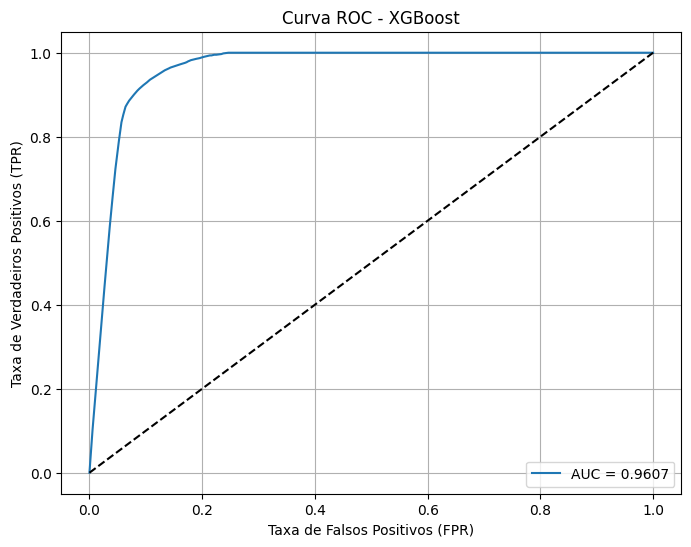

In [ ]:

# Selecionar variáveis relevantes
features = [
    'risco_relativo_idade',
    'risco_relativo_salario',
    'risco_relativo_more_90_days_overdue',
    'risco_relativo_using_lines_not_secured_personal_assets'
]
X = data[features]
y = data['default_flag']

# Treinar com toda a base
xgb_model = XGBClassifier(use_label_encoder=False, eval_metric='logloss')
xgb_model.fit(X, y)

# Previsão de probabilidade
y_probs = xgb_model.predict_proba(X)[:, 1]

# Calcular AUC-ROC
auc = roc_auc_score(y, y_probs)
print(f"AUC-ROC Score: {auc:.4f}")

# Plotando
fpr, tpr, _ = roc_curve(y, y_probs)

plt.figure(figsize=(8,6))
plt.plot(fpr, tpr, label=f'AUC = {auc:.4f}')
plt.plot([0, 1], [0, 1], 'k--')  # linha de referência
plt.title('Curva ROC - XGBoost')
plt.xlabel('Taxa de Falsos Positivos (FPR)')
plt.ylabel('Taxa de Verdadeiros Positivos (TPR)')
plt.legend(loc='lower right')
plt.grid(True)
plt.show()


##Decision Tree


A árvore de decisão é um método não-paramétrico de aprendizado supervisionado que pode ser usado tanto para classificação quanto para regressão. Ela segmenta iterativamente os dados em subconjuntos homogêneos por meio de divisões baseadas em atributos, formando uma estrutura em “árvore” com nós de decisão e nós folha que representam as classes ou valores preditos.


Decision Tree (balanceada):
[[31202  3751]
 [   40   582]]
              precision    recall  f1-score   support

         0.0       1.00      0.89      0.94     34953
         1.0       0.13      0.94      0.23       622

    accuracy                           0.89     35575
   macro avg       0.57      0.91      0.59     35575
weighted avg       0.98      0.89      0.93     35575



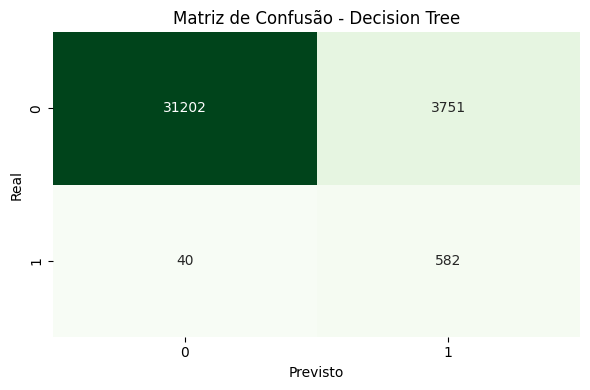

In [ ]:
# Criar modelo com peso inverso à frequência das classes
dt_model = DecisionTreeClassifier(class_weight='balanced', random_state=42)
dt_model.fit(X, y)

# Prever
y_pred = dt_model.predict(X)

# Recalcular a matriz de confusão corretamente
cm1 = confusion_matrix(y, y_pred)

# Avaliação
print("Decision Tree (balanceada):")
print(confusion_matrix(y, y_pred))
print(classification_report(y, y_pred))

# Plotar matriz de confusão
plt.figure(figsize=(6, 4))
sns.heatmap(cm1, annot=True, fmt='d', cmap='Greens', cbar=False)
plt.xlabel("Previsto")
plt.ylabel("Real")
plt.title("Matriz de Confusão - Decision Tree")
plt.tight_layout()
plt.show()



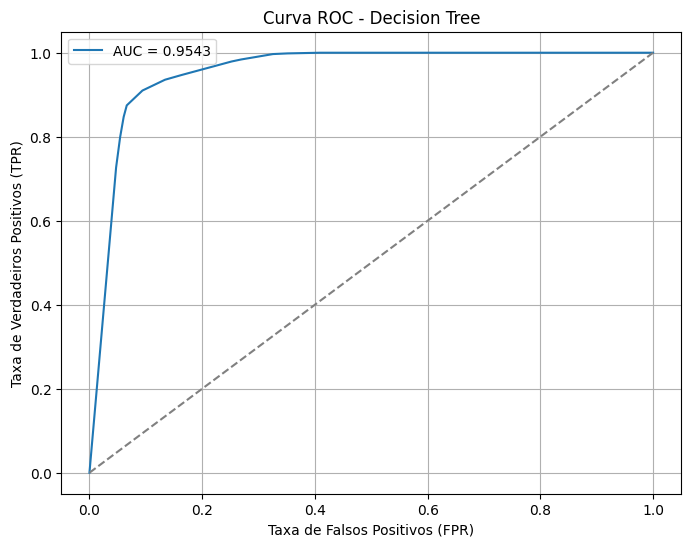

In [ ]:
# Selecionar as variáveis relevantes
features = [
    'risco_relativo_idade',
    'risco_relativo_salario',
    'risco_relativo_more_90_days_overdue',
    'risco_relativo_using_lines_not_secured_personal_assets'
]
X = data[features]
y = data['default_flag']

# Treinar modelo Decision Tree
modelo = DecisionTreeClassifier(max_depth=4, random_state=42)
modelo.fit(X, y)

# Calcular probabilidade e AUC
y_probs = modelo.predict_proba(X)[:, 1]
auc = roc_auc_score(y, y_probs)

# Curva ROC
fpr, tpr, _ = roc_curve(y, y_probs)
plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, label=f'AUC = {auc:.4f}')
plt.plot([0, 1], [0, 1], linestyle='--', color='gray')
plt.xlabel('Taxa de Falsos Positivos (FPR)')
plt.ylabel('Taxa de Verdadeiros Positivos (TPR)')
plt.title('Curva ROC - Decision Tree')
plt.legend()
plt.grid(True)
plt.show()